# CNN for synthetic image detection

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import random_split, ConcatDataset, DataLoader, Subset

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report

import tkinter as tk
from tkinterdnd2 import DND_FILES, TkinterDnD
from PIL import Image

In [39]:
celeba_dir = "data/celeba/celeba"
synthetic_dir = "data/celeba_fake/stylegan2-ada"

model_save_path = "models/cnn-sg2-2.pth"

batchSize = 32
NUM_TRAINING_SAMPLES = 8000 
NUM_VALIDATION_SAMPLES = 1000
NUM_TEST_SAMPLES = 1000
NUM_COMBINED_DATASETS = 2
epochs = 50

label_smoothing = 0.0 # try 0.1, 0.2, 0.3

kernel_size = 3
dropout_rate = 0.5  

lr = 0.0002
# todo learning rate scheduler

early_stopping_patience = 20

device = "cuda:0"
ngpu = 1

In [3]:
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)
    
class LabeledDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, label):
        self.dataset = dataset
        self.label = label

    def __getitem__(self, index):
        x, _ = self.dataset[index]
        return x, self.label

    def __len__(self):
        return len(self.dataset)
    

In [5]:
# Functions
nDatasets = 0


def calculate_mean_std(dataset):
    print("Calculating mean and std for the dataset...")
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    counter = 1
    for images, _ in dataloader:
#        images = transforms.ToTensor()(images)
        for i in range(3):
            mean[i] += images[:,i, :, :].mean()
            std[i] += images[:,i, :, :].std()
        if (counter / len(dataloader.dataset) * 100) % 10.0 == 0:
            print(f"{int(counter / len(dataloader.dataset) * 100)}%")
        counter += 1
    mean /= len(dataloader.dataset)
    std /= len(dataloader.dataset)
    return mean.numpy(), std.numpy()


def calculate_dataset_mean_std(dir, image_range):
    data = ImageFolder(dir, transform=transforms.ToTensor())
    data = torch.utils.data.Subset(data, image_range)
    mean, std = calculate_mean_std(data)
    return mean, std


def load_dataset(dir, transform, image_range, label):
    global nDatasets
    nDatasets += 1
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
        ])  
    data = ImageFolder(dir, transform=transform)
#    data = [(image, label) for image, _ in data]
    data = torch.utils.data.Subset(data, image_range)
    return data


# Display the first 64 images from the dataloader
def show_images(data, num_images=64, unnormalize=True):
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    for i, (images, labels) in enumerate(data):
        image = images[0].permute(1, 2, 0).numpy()
        if unnormalize:
            image = image * combined_std + combined_mean
        image = np.clip(image, 0, 1)
        ax = axes[i // 8, i % 8]
        ax.imshow(image)
        ax.set_title(f"{'Real' if labels[0] == 0 else 'Fake'}")
        ax.axis('off')
        if i == num_images-1:
            break
    plt.show()


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.Linear):
        if hasattr(m, 'weight') and m.weight is not None:
            if m.out_features == 1:  # Assuming the final layer with Sigmoid
                nn.init.xavier_normal_(m.weight)
            else:
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.BatchNorm2d):
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.constant_(m.weight, 1.0)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
            

In [40]:
# Data transformation to prevent overfitting
additional_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
])

celeba_data = LabeledDataset(load_dataset(celeba_dir, None, range(NUM_TRAINING_SAMPLES), label=0+label_smoothing), 0+label_smoothing)
synthetic_data = LabeledDataset(load_dataset(synthetic_dir, None, range(NUM_TRAINING_SAMPLES), label=1-label_smoothing), 1-label_smoothing)


combined_data_training = ConcatDataset([celeba_data, synthetic_data])
celeba_data = None
synthetic_data = None

combined_mean, combined_std = calculate_mean_std(combined_data_training)
print(f"combined_mean: {combined_mean}, combined_std: {combined_std}")

transform_training = transforms.Compose([
    additional_transforms,
    transforms.Normalize(mean=combined_mean, std=combined_std)
])
combined_data_training = TransformDataset(combined_data_training, transform=transform_training)

dataloader = DataLoader(combined_data_training, batch_size=batchSize, shuffle=True, num_workers=4)

assert len(dataloader.dataset) == NUM_COMBINED_DATASETS * NUM_TRAINING_SAMPLES, f"Dataset in dataloader should be {2 * NUM_TRAINING_SAMPLES} images but is {len(dataloader.dataset)}"

combined_data_training = None


# Load the validation and test set
transform_validation_test = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),    
    transforms.Normalize(mean=combined_mean, std=combined_std)])

celeba_validation = LabeledDataset(load_dataset(celeba_dir, transform_validation_test, range(NUM_TRAINING_SAMPLES,NUM_TRAINING_SAMPLES+NUM_VALIDATION_SAMPLES), label=0+label_smoothing), 0+label_smoothing)
synthetic_validation = LabeledDataset(load_dataset(synthetic_dir, transform_validation_test, range(NUM_TRAINING_SAMPLES,NUM_TRAINING_SAMPLES+NUM_VALIDATION_SAMPLES), label=1-label_smoothing), 1-label_smoothing)

combined_data_validation = ConcatDataset([celeba_validation, synthetic_validation])
validation_dataloader = DataLoader(combined_data_validation, batch_size=batchSize, shuffle=True, num_workers=4)

assert len(validation_dataloader.dataset) == NUM_COMBINED_DATASETS * NUM_VALIDATION_SAMPLES, f"Dataset in validation_dataloader should be {2 * NUM_VALIDATION_SAMPLES} images but is {len(validation_dataloader.dataset)}"
celeba_validation = None
synthetic_validation = None

celeba_test = LabeledDataset(load_dataset(celeba_dir, transform_validation_test, range(NUM_TRAINING_SAMPLES+NUM_VALIDATION_SAMPLES,NUM_TRAINING_SAMPLES+NUM_VALIDATION_SAMPLES+NUM_TEST_SAMPLES), label=0+label_smoothing), 0+label_smoothing)
synthetic_test = LabeledDataset(load_dataset(synthetic_dir, transform_validation_test, range(NUM_TRAINING_SAMPLES+NUM_VALIDATION_SAMPLES,NUM_TRAINING_SAMPLES+NUM_VALIDATION_SAMPLES+NUM_TEST_SAMPLES), label=1-label_smoothing), 1-label_smoothing)

combined_data_test = ConcatDataset([celeba_test, synthetic_test])
test_dataloader = DataLoader(combined_data_test, batch_size=batchSize, shuffle=True, num_workers=4)

assert len(test_dataloader.dataset) == NUM_COMBINED_DATASETS * NUM_TEST_SAMPLES, f"Dataset in test_dataloader should be {2 * NUM_TEST_SAMPLES} images but is {len(test_dataloader.dataset)}"
celeba_test = None
synthetic_test = None

Calculating mean and std for the dataset...
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
combined_mean: [0.5084739  0.42004415 0.3714434 ], combined_std: [0.2600403  0.23534308 0.22937723]


# CNN Architecture

In [41]:
class Cnn(nn.Module):
    def __init__(self, ngpu):
        super(Cnn, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(), 
            nn.MaxPool2d(2, 2),  
            # todo experiment with average pooling

            # 2nd Convolutional layer
            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(2, 2),

            # 3rd Convolutional layer
            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(2, 2),

            # Flatten the output volume
            nn.Flatten(),

            # Fully connected layers
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 8 * 8, 1024),  # 8*8 is the spatial dimension of the output volume
            nn.ELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Compile the model

In [42]:
cnn = Cnn(ngpu).to(device)
cnn.apply(weights_init)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr, betas=(0.5, 0.999))

# Training the model

In [42]:
train_losses_per_epoch = []
validation_losses_per_epoch = []
train_accuracies_per_epoch = []
validation_accuracies_per_epoch = []

# Early stopping to prevent overfitting
best_validation_loss = float('inf')
epochs_without_improvement = 0

print("Starting Training Loop...")
for epoch in range(epochs):
    cnn.train()
    correct = 0
    train_loss =0.0
    total = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() # Zero the parameter gradients
        outputs = cnn(inputs) # Forward pass       
        
        loss = criterion(outputs, labels.float().view(-1, 1))  # Calculate the loss
        loss.backward() # Backward pass
        optimizer.step() # Update the weights
        
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total = labels.size(0)
        correct = (predicted.view(-1) == labels).sum().item()

        if i % 100 == 0:
            print(f"Epoch: {epoch+1}, Batch: {i}/{len(dataloader)}, Loss: {loss.item()}")
            
    train_losses_per_epoch.append(train_loss / len(dataloader)) # Save the loss
    train_accuracies_per_epoch.append(100 * correct / total)
            
    # Validation phase
    cnn.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(validation_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Forward pass
            outputs = cnn(inputs)
            
            # Compute the loss
            loss = criterion(outputs, labels.float().view(-1, 1))
            validation_loss += loss.item()
            
            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.view(-1) == labels).sum().item()
    print(f"Epoch: {epoch+1}, Loss: {validation_loss / len(validation_dataloader)}, Accuracy: {100 * correct / total}% ({correct}/{total})")
    
    validation_losses_per_epoch.append(validation_loss / len(validation_dataloader))
    validation_accuracies_per_epoch.append(100 * correct / total)
    
    # Early stopping
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(cnn.state_dict(), model_save_path)
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping due to no improvement after epoch {epoch-early_stopping_patience}.")
            print()
            break
            
cnn.load_state_dict(torch.load(model_save_path))
print("Finished Training")

Starting Training Loop...
Epoch: 1, Batch: 0/500, Loss: 7.076301574707031
Epoch: 1, Batch: 100/500, Loss: 0.0077110701240599155
Epoch: 1, Batch: 200/500, Loss: 0.013094711117446423
Epoch: 1, Batch: 300/500, Loss: 0.48670879006385803
Epoch: 1, Batch: 400/500, Loss: 5.746773695136653e-06
Epoch: 1, Loss: 0.09878804791994002, Accuracy: 99.25% (1985/2000)
Epoch: 2, Batch: 0/500, Loss: 3.725290742551124e-09
Epoch: 2, Batch: 100/500, Loss: 0.0818372443318367
Epoch: 2, Batch: 200/500, Loss: 0.0
Epoch: 2, Batch: 300/500, Loss: 0.04672470688819885
Epoch: 2, Batch: 400/500, Loss: 0.0011964685982093215
Epoch: 2, Loss: 0.023263984333729275, Accuracy: 99.7% (1994/2000)
Epoch: 3, Batch: 0/500, Loss: 1.080336033965068e-07
Epoch: 3, Batch: 100/500, Loss: 0.06796813756227493
Epoch: 3, Batch: 200/500, Loss: 6.081675746827386e-05
Epoch: 3, Batch: 300/500, Loss: 0.4205479621887207
Epoch: 3, Batch: 400/500, Loss: 0.0
Epoch: 3, Loss: 0.06713106851702023, Accuracy: 99.75% (1995/2000)
Epoch: 4, Batch: 0/500, L

In [43]:
# Load the model
model_path = "models/cnn-sg2-1.pth"
cnn.load_state_dict(torch.load(model_path))
cnn.eval()

Cnn(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.5, inplace=False)
    (14): Linear(in_features=16384, out_features=1024, bias=True)
  

Confusion Matrix:
[[999   1]
 [  1 999]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1000
     Class 1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



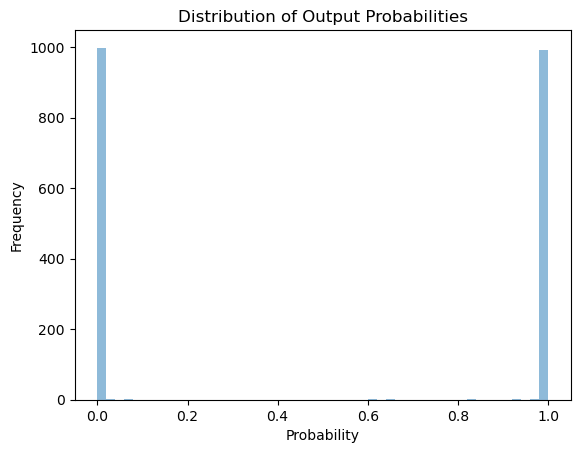

[2.36971697e-14 8.38855684e-01 4.60965018e-16 ... 1.00000000e+00
 1.75826080e-19 1.11628046e-12]


In [44]:
true_labels = []
pred_labels = []
output_probabilities = []

# We don't need to compute gradients for this step
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = cnn(images)
        # Get the predicted class with the highest score
        predicted = (outputs > 0.5).float()
        # Append labels
        true_labels.extend(labels.view(-1).cpu().numpy())
        pred_labels.extend(predicted.view(-1).cpu().numpy())

        output_probabilities = np.append(output_probabilities, outputs.cpu().numpy())


# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Class 0", "Class 1"]))

# Plot histogram of output probabilities
plt.hist(output_probabilities, bins=50, alpha=0.5)
plt.title('Distribution of Output Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

print(output_probabilities)

In [45]:
correct = 0
total = 0

with torch.no_grad(): # No need to calculate the gradients
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = cnn(images)
        # Get the predicted class with the highest score
        predicted = (outputs > 0.5).float()
        # Count total and correct predictions
        total += labels.size(0)
        correct += (predicted.view(-1) == labels).sum().item()

print(f"Accuracy of the model on test images: {100 * correct / total}% ({correct}/{total})")

Accuracy of the model on test images: 99.9% (1998/2000)


In [45]:
# Real or Synthetic Image Detector GUI with drag and drop
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=combined_mean, std=combined_std)])

def drop(event):
    print(event.data)  # Add this line to print event.data
    image_path = event.data.replace("{", "").replace("}", "").replace("'", "")
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    output = cnn(image)
    result = (output > 0.5).item()
    if result == 1:
        result_text.set("The image is synthetic.")
    else:
        result_text.set("The image is real.")

root = TkinterDnD.Tk()
root.title("Real or Synthetic Image Detector")

result_text = tk.StringVar()
result_label = tk.Label(root, textvariable=result_text)
result_label.pack()

drop_target = tk.Label(root, text="Drag and Drop Image Here", bg="white", width=40, height=20)
drop_target.pack()

drop_target.drop_target_register(DND_FILES)
drop_target.dnd_bind('<<Drop>>', drop)

root.mainloop()

{/home/marc/PycharmProjects/Vision Deep Learning Basics/data/celeba_fake/ProgGAN/Pictures/ec8a4ddb073246c5b83e7b78623d3262.png}
{/home/marc/PycharmProjects/Vision Deep Learning Basics/data/celeba_fake/ProgGAN/Pictures/ebba423fde3546ce924663f20cbacc10.png}
{/home/marc/PycharmProjects/Vision Deep Learning Basics/data/celeba_fake/ProgGAN/Pictures/eae6bce41e024d3496babb073ebc0377.png}
{/home/marc/PycharmProjects/Vision Deep Learning Basics/data/celeba_fake/ProgGAN/Pictures/ea16436fd51d4fa1890a5f3d3dcdc5d5.png}
{/home/marc/PycharmProjects/Vision Deep Learning Basics/data/celeba/celeba/img_align_celeba/202272.jpg}


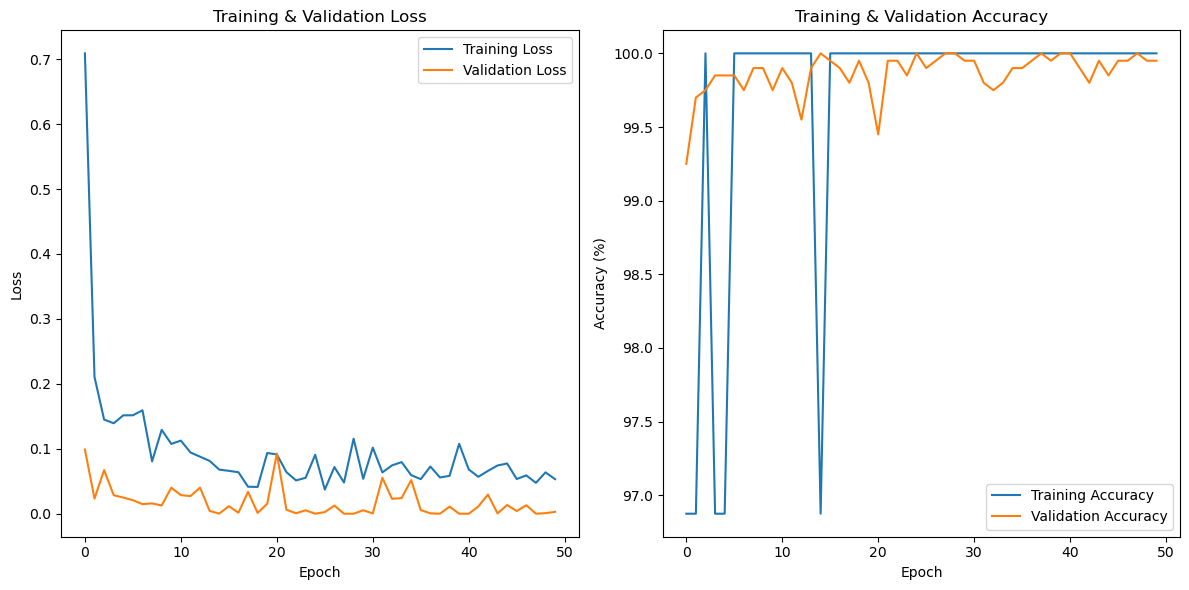

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axs[0].plot(train_losses_per_epoch, label='Training Loss')
axs[0].plot(validation_losses_per_epoch, label='Validation Loss')
axs[0].set_title('Training & Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(train_accuracies_per_epoch, label='Training Accuracy')
axs[1].plot(validation_accuracies_per_epoch, label='Validation Accuracy')
axs[1].set_title('Training & Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()
# validation loss > training loss -> overfitting
# validation loss < training loss -> underfitting